In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

In [2]:
data=pd.read_csv(r'../Desktop/Electric_Production.csv')

In [3]:
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [4]:
type(data['DATE'][0])

str

In [5]:
data['DATE']=pd.to_datetime(data['DATE'])

In [6]:
data

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [7]:
data.isna().sum()

DATE          0
IPG2211A2N    0
dtype: int64

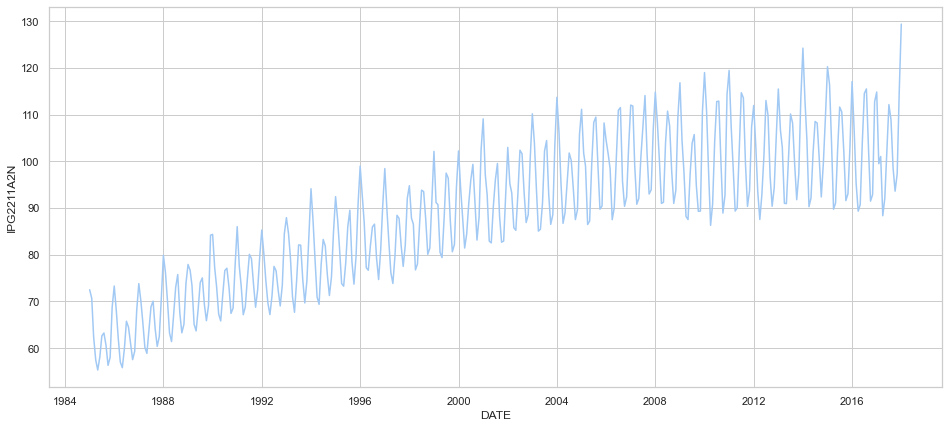

In [8]:

plt.figure(figsize=(16,7))
sns.set_theme(style="whitegrid", palette="pastel")
sns.lineplot(x=data['DATE'],y=data['IPG2211A2N']);
plt.show()

Data shows a seasonality and also an upward trend. Hence, data is non-stationary.



In [9]:
len(data)

397

In [10]:
data=data.set_index('DATE')

Checking if Data is Non-Stationary/Stationary

In [11]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data['IPG2211A2N'])


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [12]:
print(f"p-value: {pvalue}")

p-value: 0.1862146911658734


Here, p-value is greater than 0.05. So we fail to reject the null hypothesis that the data is non-stationary. Hence, confirmed, the data is non-stationary.

In [13]:
train=data.iloc[:round(0.70*len(data))]
test=data.iloc[round(0.70*len(data)):]

In [14]:
#function to prepare the data in batches of train data and corresponding value

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [15]:
window_size = 6
batch_size = 32
shuffle_buffer_size = 1000


train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size)

In [16]:
train_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

Simple LSTM model

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import keras

In [18]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
model.fit(train_set,epochs=50)

Epoch 1/50
9/9 [==============================] - 5s 175ms/step - loss: 8746.6904
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 5850.8838
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 1369.0031
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 177.7924
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 81.3832
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 64.8855
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 46.0328
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 38.7635
Epoch 9/50
9/9 [==============================] - 0s 8ms/step - loss: 32.8877
Epoch 10/50
9/9 [==============================] - 0s 9ms/step - loss: 28.0722
Epoch 11/50
9/9 [==============================] - 0s 9ms/step - loss: 21.6130
Epoch 12/50
9/9 [==============================] - 0s 11ms/step - loss: 17.9329
Epoch 13/50
9/9 [==============================] - 

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


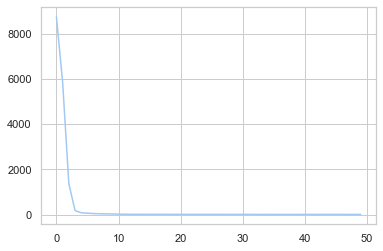

In [20]:
loss=model.history.history['loss']
sns.lineplot(range(len(loss)),loss);

In [21]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [22]:
# Reduce the original series
forecast_series = data['IPG2211A2N'][round(0.70*len(data))-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

In [23]:
results

array([100.26812 ,  93.64652 ,  92.69584 , 100.4361  , 112.42904 ,
       109.50205 ,  99.46331 ,  91.05936 ,  92.60073 , 104.008385,
       117.41215 , 109.56989 ,  96.33448 ,  92.374275,  93.20542 ,
        95.43055 , 105.21118 , 105.92745 ,  97.99346 ,  88.30381 ,
        89.08564 , 100.71937 , 117.48745 , 109.14902 ,  99.04968 ,
        90.95909 ,  90.63414 , 102.475426, 111.47631 , 109.909386,
       100.50492 ,  91.65319 ,  89.75233 , 105.00068 , 120.838646,
       112.67962 ,  97.91977 ,  92.51467 ,  95.20815 ,  98.55434 ,
       111.16767 , 111.137   , 101.87966 ,  91.4159  ,  90.878395,
       105.79159 , 114.89803 , 110.15179 ,  96.090256,  89.26882 ,
        97.469795, 102.16684 , 107.21175 , 105.94279 ,  98.73257 ,
        89.74183 ,  92.981895, 105.38912 , 112.352425, 110.17155 ,
        98.08724 ,  95.114586,  90.86283 , 100.588264, 109.03556 ,
       111.41866 , 100.93485 ,  91.97763 ,  91.13027 , 110.26406 ,
       121.182014, 112.1305  , 102.17776 ,  96.600914,  93.078

In [24]:
len(results)

119

In [25]:
test['preds']=results

C:\Users\User\AppData\Local\Temp/ipykernel_2440/1471460237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds']=results


In [26]:
test

,IPG2211A2N,preds
DATE,,
2008-03-01,100.4386,100.268120
2008-04-01,90.9944,93.646523
2008-05-01,91.2348,92.695839
2008-06-01,103.9581,100.436096
2008-07-01,110.7631,112.429039
...,...,...
2017-09-01,98.6154,100.152534
2017-10-01,93.6137,91.159531
2017-11-01,97.3359,94.032097


<AxesSubplot:xlabel='DATE'>

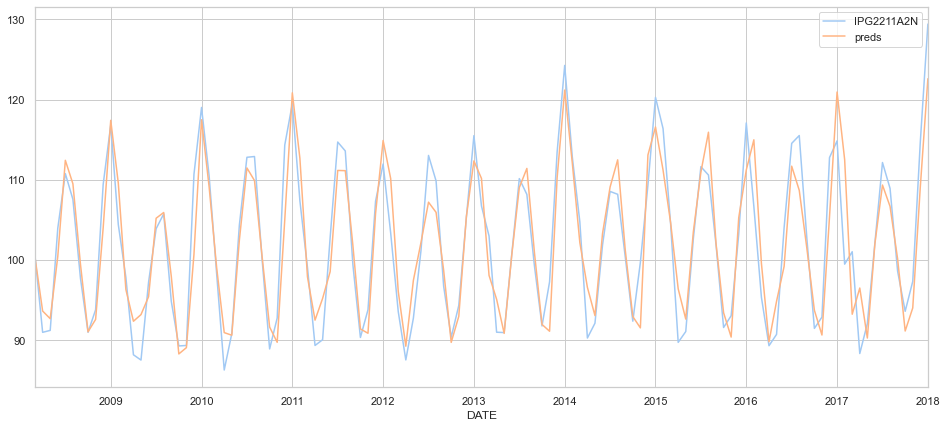

In [27]:
test.plot(figsize=(16,7))

In [28]:
print(keras.metrics.mean_squared_error(test['IPG2211A2N'],test['preds']))

tf.Tensor(15.224347, shape=(), dtype=float32)


In [29]:
print(keras.metrics.mean_absolute_error(test['IPG2211A2N'],test['preds']))

tf.Tensor(3.0289922, shape=(), dtype=float32)


**Increasing number of layers/hyperparameter tuning**

In [30]:
from keras.layers import Bidirectional

In [31]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(100, activation='relu', input_shape=(window_size,1))))
#mode1l.add(LSTM(64))
model1.add(Dense(32,activation='relu'))
model1.add(Dense(16,activation='relu'))
model1.add(Dense(8,activation='relu'))
model1.add(Dense(1))

In [32]:
model1.compile(loss="mse", optimizer='adam')

In [33]:
history=model1.fit(train_set,epochs=100)

Epoch 1/100
9/9 [==============================] - 5s 15ms/step - loss: 3440.3647
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 235.1401
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 75.3431
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 45.8351
Epoch 5/100
9/9 [==============================] - 0s 11ms/step - loss: 37.5217
Epoch 6/100
9/9 [==============================] - 0s 12ms/step - loss: 28.3143
Epoch 7/100
9/9 [==============================] - 0s 10ms/step - loss: 21.3973
Epoch 8/100
9/9 [==============================] - 0s 12ms/step - loss: 21.3282
Epoch 9/100
9/9 [==============================] - 0s 11ms/step - loss: 19.5685
Epoch 10/100
9/9 [==============================] - 0s 14ms/step - loss: 18.5325
Epoch 11/100
9/9 [==============================] - 0s 13ms/step - loss: 18.4567
Epoch 12/100
9/9 [==============================] - 0s 10ms/step - loss: 17.3609
Epoch 13/100
9/9 [================

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


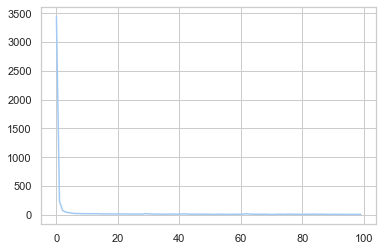

In [34]:
loss=history.history['loss']
sns.lineplot(range(len(loss)),loss);

In [35]:
# Reduce the original series
forecast_series = data['IPG2211A2N'][round(0.70*len(data))-window_size:-1]

forecast = model_forecast(model1, forecast_series, window_size, batch_size)
results = forecast.squeeze()

In [36]:
print(keras.metrics.mean_squared_error(test['IPG2211A2N'],results))

tf.Tensor(13.202334, shape=(), dtype=float32)


In [37]:
test

,IPG2211A2N,preds
DATE,,
2008-03-01,100.4386,100.268120
2008-04-01,90.9944,93.646523
2008-05-01,91.2348,92.695839
2008-06-01,103.9581,100.436096
2008-07-01,110.7631,112.429039
...,...,...
2017-09-01,98.6154,100.152534
2017-10-01,93.6137,91.159531
2017-11-01,97.3359,94.032097


In [38]:
results

array([101.85618 ,  90.36694 ,  91.48198 ,  99.762535, 109.692444,
       108.25444 , 100.090034,  88.64528 ,  92.488846, 104.70584 ,
       115.48013 , 107.065094,  99.59867 ,  89.01287 ,  87.24826 ,
        96.177864, 103.67991 , 104.74346 ,  97.02693 ,  87.86705 ,
        90.29347 , 101.38193 , 115.56251 , 106.83276 ,  99.815475,
        87.13083 ,  85.89331 ,  99.63555 , 109.59156 , 107.10553 ,
        99.622284,  89.56114 ,  89.354095, 105.28358 , 117.602936,
       109.12866 , 100.68016 ,  88.197495,  87.87792 , 100.227425,
       108.525246, 110.60656 , 100.75206 ,  90.55435 ,  89.864456,
       104.31778 , 112.86929 , 107.11359 ,  98.82341 ,  88.4057  ,
        88.5919  , 101.40588 , 107.850845, 103.88455 ,  98.26802 ,
        89.32932 ,  92.64896 , 103.89938 , 112.01178 , 107.432655,
        99.61084 ,  90.82684 ,  91.77569 ,  99.28904 , 107.09366 ,
       111.13656 , 100.52723 ,  90.73672 ,  93.21682 , 111.46007 ,
       119.17847 , 109.68826 , 103.65391 ,  91.931854,  90.200

In [39]:
test['preds1']=results

C:\Users\User\AppData\Local\Temp/ipykernel_2440/1114361109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds1']=results


In [40]:
test

,IPG2211A2N,preds,preds1
DATE,,,
2008-03-01,100.4386,100.268120,101.856178
2008-04-01,90.9944,93.646523,90.366943
2008-05-01,91.2348,92.695839,91.481979
2008-06-01,103.9581,100.436096,99.762535
2008-07-01,110.7631,112.429039,109.692444
...,...,...,...
2017-09-01,98.6154,100.152534,99.897781
2017-10-01,93.6137,91.159531,89.538055
2017-11-01,97.3359,94.032097,95.128807


In [41]:
print(tf.keras.metrics.mean_squared_error(test['IPG2211A2N'], results).numpy())
print(tf.keras.metrics.mean_absolute_error(test['IPG2211A2N'], results).numpy())

13.202334
2.786152


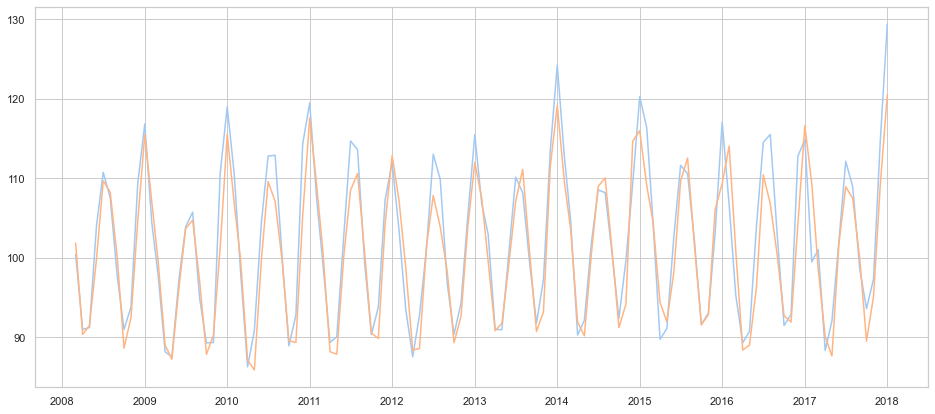

In [42]:
plt.figure(figsize=(16,7))
plt.plot(test['IPG2211A2N']);
plt.plot(test['preds1']);


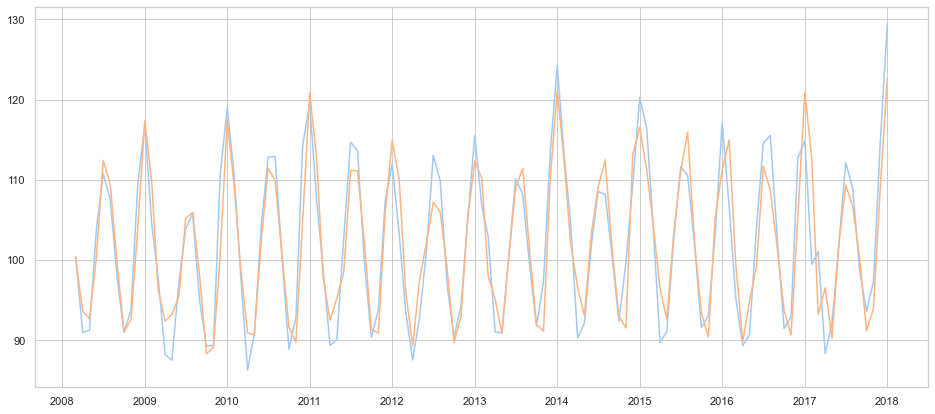

In [43]:
plt.figure(figsize=(16,7))
plt.plot(test['IPG2211A2N']);
plt.plot(test['preds']);


Making the data stationary and then applying LSTM

In [44]:
data['Biannual_first_differnce']=data['IPG2211A2N']-data['IPG2211A2N'].shift(6)

In [45]:
data.head(100)

,IPG2211A2N,Biannual_first_differnce
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,NaN
1985-03-01,62.4502,NaN
1985-04-01,57.4714,NaN
1985-05-01,55.3151,NaN
...,...,...
1992-12-01,84.5159,13.3081
1993-01-01,87.9464,10.4383
1993-02-01,84.5561,8.0187


In [46]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data['Biannual_first_differnce'].dropna())


In [47]:
print(f"P-value:{pvalue}")

P-value:3.138120852278712e-09


<AxesSubplot:xlabel='DATE'>

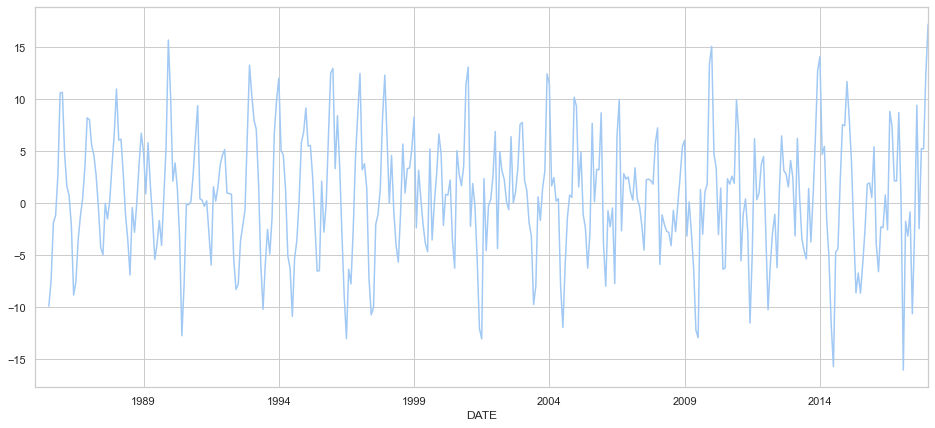

In [48]:
data['Biannual_first_differnce'].plot(figsize=(16,7))

In [49]:
sub=data.drop(['IPG2211A2N'],axis=1).dropna()
train=sub.iloc[:round(0.70*len(data))]
test=sub.iloc[round(0.70*len(data)):]

In [50]:
train

,Biannual_first_differnce
DATE,
1985-07-01,-9.8850
1985-08-01,-7.4235
1985-09-01,-1.8656
1985-10-01,-1.1560
1985-11-01,2.6854
...,...
2008-04-01,-2.0124
2008-05-01,-2.6778
2008-06-01,-2.7947


In [51]:
test

,Biannual_first_differnce
DATE,
2008-09-01,-2.7203
2008-10-01,0.0035
2008-11-01,2.5709
2008-12-01,5.4640
2009-01-01,6.0685
...,...
2017-09-01,-2.4242
2017-10-01,5.2607
2017-11-01,5.2554


In [52]:
window_size = 6
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size)

In [53]:
model_ = Sequential()
model_.add(LSTM(100, activation='relu', input_shape=(window_size,1)))
model_.add(Dense(32,activation='relu'))
model_.add(Dense(16, activation='relu'))
model_.add(Dense(8,activation='relu'))
model_.add(Dense(1))
#model_.compile(optimizer='adam', loss='mse')

In [54]:
# Set the training parameters
model_.compile(loss="mse", optimizer='adam')

In [55]:
model_.fit(train_set,epochs=100)

Epoch 1/100
9/9 [==============================] - 3s 12ms/step - loss: 30.7563
Epoch 2/100
9/9 [==============================] - 0s 9ms/step - loss: 29.6342
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 26.1999
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 20.5495
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 14.4013
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 12.0883
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 12.0242
Epoch 8/100
9/9 [==============================] - 0s 8ms/step - loss: 11.3745
Epoch 9/100
9/9 [==============================] - 0s 8ms/step - loss: 10.4050
Epoch 10/100
9/9 [==============================] - 0s 8ms/step - loss: 10.1454
Epoch 11/100
9/9 [==============================] - 0s 8ms/step - loss: 9.8364
Epoch 12/100
9/9 [==============================] - 0s 9ms/step - loss: 9.8364
Epoch 13/100
9/9 [==============================]

In [56]:
forecast_series = sub['Biannual_first_differnce'][round(0.70*len(sub))-window_size:-5]

# Use helper function to generate predictions
forecast = model_forecast(model_, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
#plot_series(time_valid, (x_valid, results))

In [57]:
forecast_series

DATE
2007-11-01     1.8539
2007-12-01     5.7852
2008-01-01     7.2645
2008-02-01    -5.8683
2008-03-01    -1.0930
               ...   
2017-04-01    -3.1337
2017-05-01    -0.8095
2017-06-01   -10.6162
2017-07-01    -2.6967
2017-08-01     9.4411
Name: Biannual_first_differnce, Length: 118, dtype: float64

In [58]:
results

array([ -2.0075164 ,  -2.8302357 ,  -4.88824   ,   4.2139874 ,
         2.3381653 ,   2.776444  ,   4.3507967 ,   6.869154  ,
         8.150319  ,   3.1942377 ,   2.9587247 ,   1.024911  ,
        -3.3170838 ,  -3.582687  ,  -5.611725  ,   2.3859124 ,
        -1.4672723 ,   1.4930191 ,   2.9277267 ,   3.8594112 ,
        10.436884  ,   2.1092644 ,   5.251751  ,   1.1165737 ,
        -5.3423223 ,  -8.900778  , -16.053646  ,  -2.0711074 ,
         0.46896803,   5.101929  ,   1.4148297 ,   6.1862917 ,
        12.270646  ,  -0.62261754,  -1.0385172 ,  -1.2866082 ,
        -1.9378743 ,  -6.019645  ,  -7.3772855 ,   6.534818  ,
         3.0089743 ,   1.0243545 ,   2.975472  ,   6.3282237 ,
         5.154011  ,  -5.5313344 ,  -1.8827319 ,   0.44757527,
        -0.97754663,  -1.8039385 ,   2.9527645 ,   7.2529793 ,
        12.250668  ,   4.219329  ,   3.9304533 ,   6.388384  ,
         1.3582861 ,  -1.7994567 ,  -1.7971597 ,   0.6554751 ,
         0.9067021 ,  -3.80147   ,  -0.8117266 ,   4.63

In [59]:
test['res_after_stationary']=results

C:\Users\User\AppData\Local\Temp/ipykernel_2440/300129441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['res_after_stationary']=results


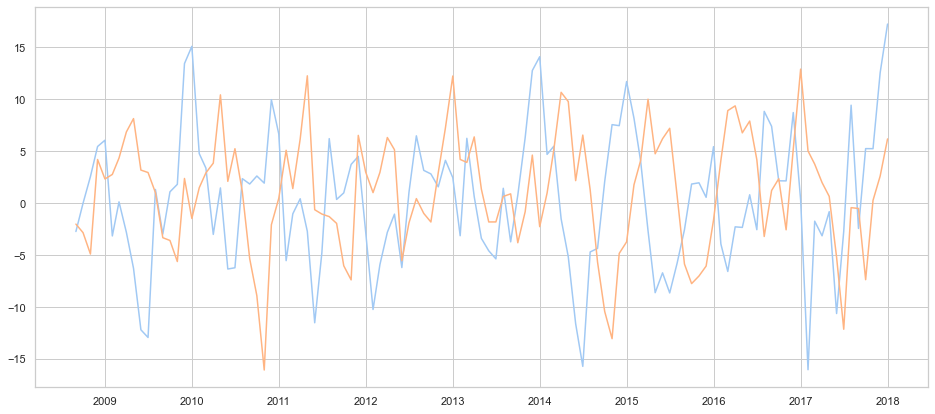

In [60]:
plt.figure(figsize=(16,7))
plt.plot(test['Biannual_first_differnce']);

plt.plot(test['res_after_stationary']);


In [61]:
test['Biannual_first_differnce']

DATE
2008-09-01    -2.7203
2008-10-01     0.0035
2008-11-01     2.5709
2008-12-01     5.4640
2009-01-01     6.0685
               ...   
2017-09-01    -2.4242
2017-10-01     5.2607
2017-11-01     5.2554
2017-12-01    12.5680
2018-01-01    17.2510
Name: Biannual_first_differnce, Length: 113, dtype: float64

In [62]:
test['res_after_stationary']

DATE
2008-09-01   -2.007516
2008-10-01   -2.830236
2008-11-01   -4.888240
2008-12-01    4.213987
2009-01-01    2.338165
                ...   
2017-09-01   -0.500611
2017-10-01   -7.358086
2017-11-01    0.278600
2017-12-01    2.619220
2018-01-01    6.193428
Name: res_after_stationary, Length: 113, dtype: float32